In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    roc_curve,
    auc
)
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    KFold,
    learning_curve
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import stats
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

Fase 1: Business Understanding

El banco Monopoly, con años de trayectoria atendiendo clientes en Chile, ha sido adquirido recientemente por el banco extranjero Dormammu. Este cambio estratégico busca aprovechar el mercado chileno y optimizar la relación con los clientes de Monopoly mediante un análisis profundo de su comportamiento financiero.

Como parte del equipo de ingenieros de Dormammu, se nos ha encomendado el desafío de analizar una base de datos proporcionada por Monopoly. Esta contiene información detallada de 12 meses para 51,124 clientes, organizada en 574 variables que incluyen características demográficas, financieras y comportamentales. El objetivo principal es extraer patrones, identificar segmentos y generar insumos valiosos para diseñar estrategias que potencien la gestión de estos clientes bajo la nueva administración.

Objetivo
Entender el comportamiento de los clientes del banco Monopoly mediante el análisis de sus datos históricos, para ofrecer insights clave que orienten la estrategia comercial y operativa de Dormammu.

Preguntas clave
¿Qué factores sociodemográficos, como región, renta y edad, influyen en el uso de productos financieros?
¿Los clientes con múltiples productos financieros (dualidad) generan más ingresos y transacciones que los clientes monoproducto?
¿Cómo afecta la antigüedad del cliente en el banco a su nivel de actividad y uso de líneas de crédito?
¿Qué patrones de comportamiento se pueden identificar en el uso de tarjetas de crédito y débito según el subsegmento del cliente?

In [78]:
ds = pd.read_excel('../data/01_raw/Base_clientes_Monopoly.xlsx')

To begin with the exploratory analysis, it is essential to identify and understand the information contained in each of the datasets we will be using. Below is a summary of the three main datasets involved in our study.

The proposed dataset has errors so, before anything else, we will apply a function that orders the shape of the sataset to be able to work with it

In [79]:
ds.columns = ds.iloc[0]  
ds = ds[1:]
ds.reset_index(drop=True, inplace=True)

In [80]:
ds.head(8)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target,NaN
0,1,160,M,13,43,NaN,130,1,1,0,...,33000,0,1099866,0,1099866,15080,0,R,0,NaN
1,2,160,H,13,46,143640,69,1,0,0,...,300000,0,214592,0,214592,83596,0,R,0,NaN
2,3,170,H,13,45,929106,24,1,1,0,...,216676,0,0,0,7400,0,0,T,0,NaN
3,4,151,H,13,46,172447,134,0,1,0,...,60000,0,272762,0,272762,10591,0,R,0,NaN
4,5,170,H,13,46,805250,116,0,1,1,...,272925,0,249562,0,75339,377782,0,R,0,NaN
5,6,170,H,13,47,707664,67,1,1,0,...,35800,0,35800,0,0,51197,0,R,0,NaN
6,7,811,H,13,48,1022833,21,1,0,1,...,9391,0,8818,0,8818,0,0,T,0,NaN
7,8,170,H,13,46,NaN,69,0,1,1,...,6000,0,283520,0,283520,0,0,R,0,NaN


In the data preparation process, the first row of the DataFrame `db` is assigned as the column names since the original Excel file contained numbers instead of descriptive names. This is crucial for facilitating the identification and handling of the data in subsequent analyses. Next, this first row is removed from the DataFrame, ensuring that only the relevant data remains for analysis and avoiding confusion from duplicate data. Following this, the index of the DataFrame is reset to keep it clean and organized, which is a good practice in data preparation. Finally, the new column names and the first few rows of the DataFrame are printed to verify that the operations have been executed correctly. This verification is essential in the CRISP-DM methodology to ensure that the data is properly structured before proceeding with exploratory analysis and modeling.

Fase 2: Data Understanding

In [81]:
ds.describe()

,NaN
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [82]:
ds.isna().sum()


0
Id                 0
Subsegmento        0
Sexo               1
Region            53
Edad               0
               ...  
UsoL2_T01          0
UsoLI_T01          0
IndRev_T01         0
target             0
NaN            51124
Length: 575, dtype: int64

In [83]:
print(ds.dtypes)

0
Id              object
Subsegmento     object
Sexo            object
Region          object
Edad            object
                ...   
UsoL2_T01       object
UsoLI_T01       object
IndRev_T01      object
target          object
NaN            float64
Length: 575, dtype: object


In [84]:
   print(len(ds.columns))  # Esto te mostrará el número de columnas

575


In [85]:
conteo_filas = ds.count()

# Mostrar el conteo de filas por columna
print(conteo_filas)


0
Id             51124
Subsegmento    51124
Sexo           51123
Region         51071
Edad           51124
               ...  
UsoL2_T01      51124
UsoLI_T01      51124
IndRev_T01     51124
target         51124
NaN                0
Length: 575, dtype: int64


In [86]:
# Contar el número total de filas en el DataFrame
numero_total_filas = ds.shape[0]
print(f'Número total de filas: {numero_total_filas}')

Número total de filas: 51124


In [87]:
description = ds.describe()
for column in description.columns:
    print(f"Analysis of {column}:")

    mean_value = description[column].mean(skipna=True)
    print(f" - Mean (Average): {mean_value:.2f} ")

    median_value = description[column].median(skipna=True)
    print(f" - Median: {median_value:.2f} ")

Analysis of nan:
 - Mean (Average): 0.00 
 - Median: 0.00 


Fase 3: Data Preparation

In [88]:
ds.drop(columns=ds.columns[-1], inplace=True)

In [89]:
columnas_deseadas = [
    'Id', 'Region', 'Renta', 'Sexo', 'Subsegmento', 'Edad', 
    'Adicional', 'Antiguedad', 'CambioPin', 'Consumo', 'Debito', 'Ctacte', 
    'Cuentas', 'Hipotecario', 'Internauta', 'Monoproducto', 'TC', 'Dualidad', 
    'CUPO_L1', 'CUPO_MX', 'CUPO_L2', 'Col_T12', 'ColL1TE_T12', 'EeccInt_T12', 
    'EeccNac_T12', 'Fac_T12', 'FacAI_T12', 'FacAN_T12', 'FacCCOT_T12', 
    'FacCCPC_T12', 'FacCI_T12', 'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 
    'FacDebCom_T12', 'FacPAT_T12', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12', 
    'FlgActCCOT_T12', 'FlgActCCPC_T12', 'FlgActCI_T12', 'FlgActCN_T12', 
    'FlgActCOL_T12', 'FlgActPAT_T12', 'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 
    'TxsAI_T12', 'TxsAN_T12', 'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12', 
    'TxsCN_T12', 'TxsCOL_T12', 'TxsDebAtm_T12', 'TxsDebCom_T12', 'TxsPAT_T12', 
    'UsoL1_T12', 'UsoL2_T12', 'UsoLI_T12'
]
ds = ds[columnas_deseadas]

In [17]:
for col in ds.columns:
    if col != 'Sexo':
        ds[col] = pd.to_numeric(ds[col], errors='coerce')

In [18]:
# Inicializa el KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Aplica el imputer a todas las columnas numéricas
columnas_numericas = ds.select_dtypes(include=['number']).columns
ds[columnas_numericas] = imputer.fit_transform(ds[columnas_numericas])

In [19]:
ds = ds.dropna(subset=['Sexo'])

In [20]:
ds[columnas_numericas] = ds[columnas_numericas].astype(int)


In [21]:
ds2 = ds

In [22]:
ds2.count()


0
Id               51123
Region           51123
Renta            51123
Sexo             51123
Subsegmento      51123
                 ...  
TxsDebCom_T12    51123
TxsPAT_T12       51123
UsoL1_T12        51123
UsoL2_T12        51123
UsoLI_T12        51123
Length: 61, dtype: int64

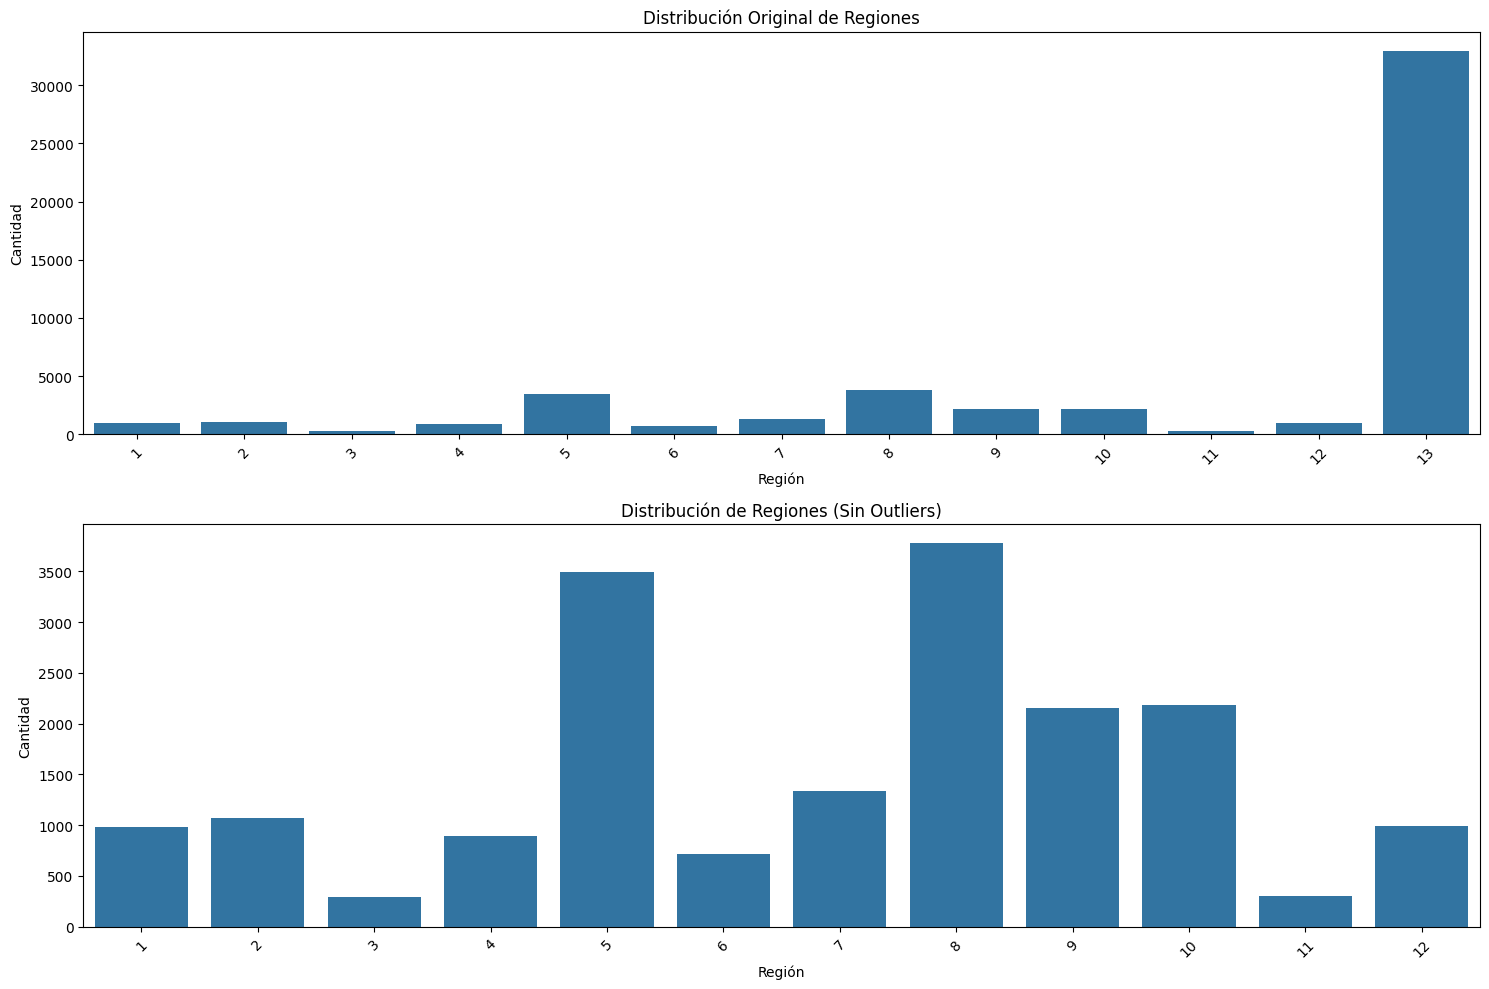


Estadísticas del filtrado:
Regiones originales: 13
Regiones después del filtrado: 12
Regiones eliminadas: 1

Regiones eliminadas:
{13}

Registros originales: 51123
Registros después del filtrado: 18183
Registros eliminados: 32940
Porcentaje de registros eliminados: 64.43%


In [23]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Contar filas por región
conteo_region = ds['Region'].value_counts()

# Calcular Z-scores del conteo de regiones
z_scores = np.abs(stats.zscore(conteo_region))

# Identificar regiones representativas (|z| < 3)
regiones_representativas = conteo_region[z_scores < 3].index

# Crear ds2 solo con las regiones representativas
ds2 = ds[ds['Region'].isin(regiones_representativas)]

# Visualización antes y después
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico original
sns.barplot(x=conteo_region.index, y=conteo_region.values, ax=ax1)
ax1.set_title('Distribución Original de Regiones')
ax1.set_xlabel('Región')
ax1.set_ylabel('Cantidad')
ax1.tick_params(axis='x', rotation=45)

# Gráfico después de eliminar regiones poco representativas
conteo_region_nuevo = ds2['Region'].value_counts()
sns.barplot(x=conteo_region_nuevo.index, y=conteo_region_nuevo.values, ax=ax2)
ax2.set_title('Distribución de Regiones (Sin Outliers)')
ax2.set_xlabel('Región')
ax2.set_ylabel('Cantidad')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar estadísticas
print("\nEstadísticas del filtrado:")
print(f"Regiones originales: {len(conteo_region)}")
print(f"Regiones después del filtrado: {len(conteo_region_nuevo)}")
print(f"Regiones eliminadas: {len(conteo_region) - len(conteo_region_nuevo)}")
print("\nRegiones eliminadas:")
print(set(conteo_region.index) - set(conteo_region_nuevo.index))
print("\nRegistros originales:", len(ds))
print("Registros después del filtrado:", len(ds2))
print(f"Registros eliminados: {len(ds) - len(ds2)}")
print(f"Porcentaje de registros eliminados: {((len(ds) - len(ds2))/len(ds)*100):.2f}%")

Análisis detallado por región:
        Conteo   Z-score  Porcentaje
Region                              
13       32940  3.436633       64.43
8         3773  0.018901        7.38
5         3489  0.052548        6.82
10        2187  0.206801        4.28
9         2151  0.211066        4.21
7         1334  0.307860        2.61
2         1072  0.338900        2.10
12         995  0.348022        1.95
1          979  0.349918        1.91
4          889  0.360581        1.74
6          721  0.380484        1.41
11         299  0.430480        0.58
3          294  0.431073        0.58


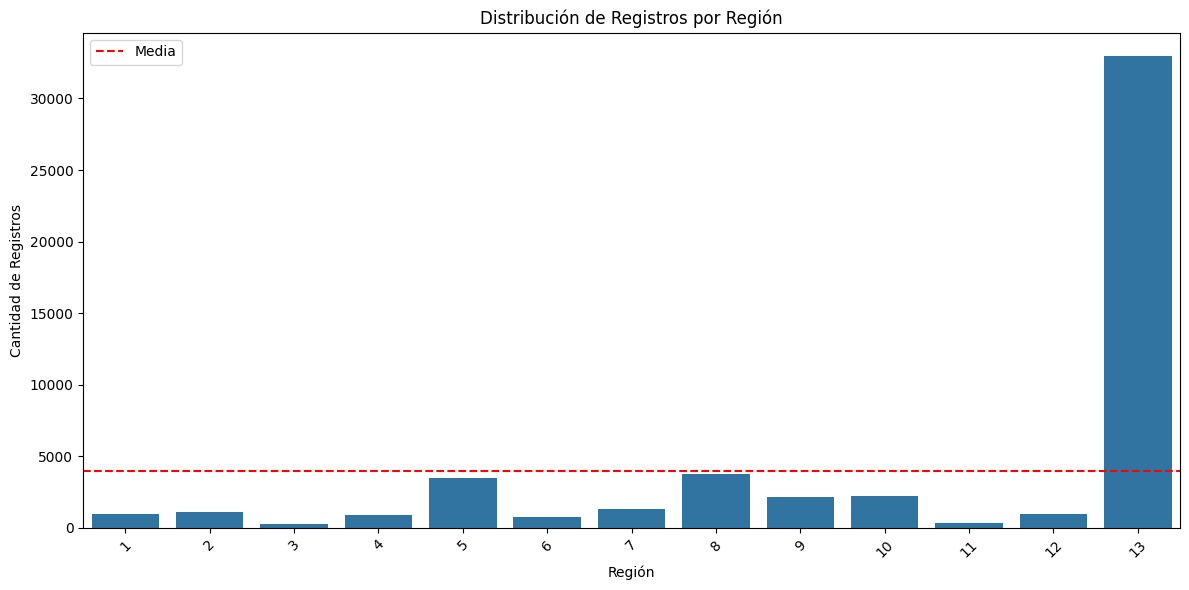


Estadísticas descriptivas:
count       13.000000
mean      3932.538462
std       8785.319484
min        294.000000
25%        889.000000
50%       1072.000000
75%       2187.000000
max      32940.000000
Name: count, dtype: float64


In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Contar filas por región
conteo_region = ds['Region'].value_counts()

# Calcular Z-scores del conteo de regiones
z_scores = np.abs(stats.zscore(conteo_region))

# Mostrar análisis detallado
analisis = pd.DataFrame({
    'Conteo': conteo_region,
    'Z-score': z_scores,
    'Porcentaje': (conteo_region/len(ds)*100).round(2)
})

print("Análisis detallado por región:")
print(analisis)

# Visualizar la distribución
plt.figure(figsize=(12, 6))
sns.barplot(x=conteo_region.index, y=conteo_region.values)
plt.title('Distribución de Registros por Región')
plt.xlabel('Región')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.axhline(y=conteo_region.mean(), color='r', linestyle='--', label='Media')
plt.legend()
plt.tight_layout()
plt.show()

print("\nEstadísticas descriptivas:")
print(conteo_region.describe())

Distribución original:
Region
13    32940
8      3773
5      3489
10     2187
9      2151
7      1334
2      1072
12      995
1       979
4       889
6       721
11      299
3       294
Name: count, dtype: int64


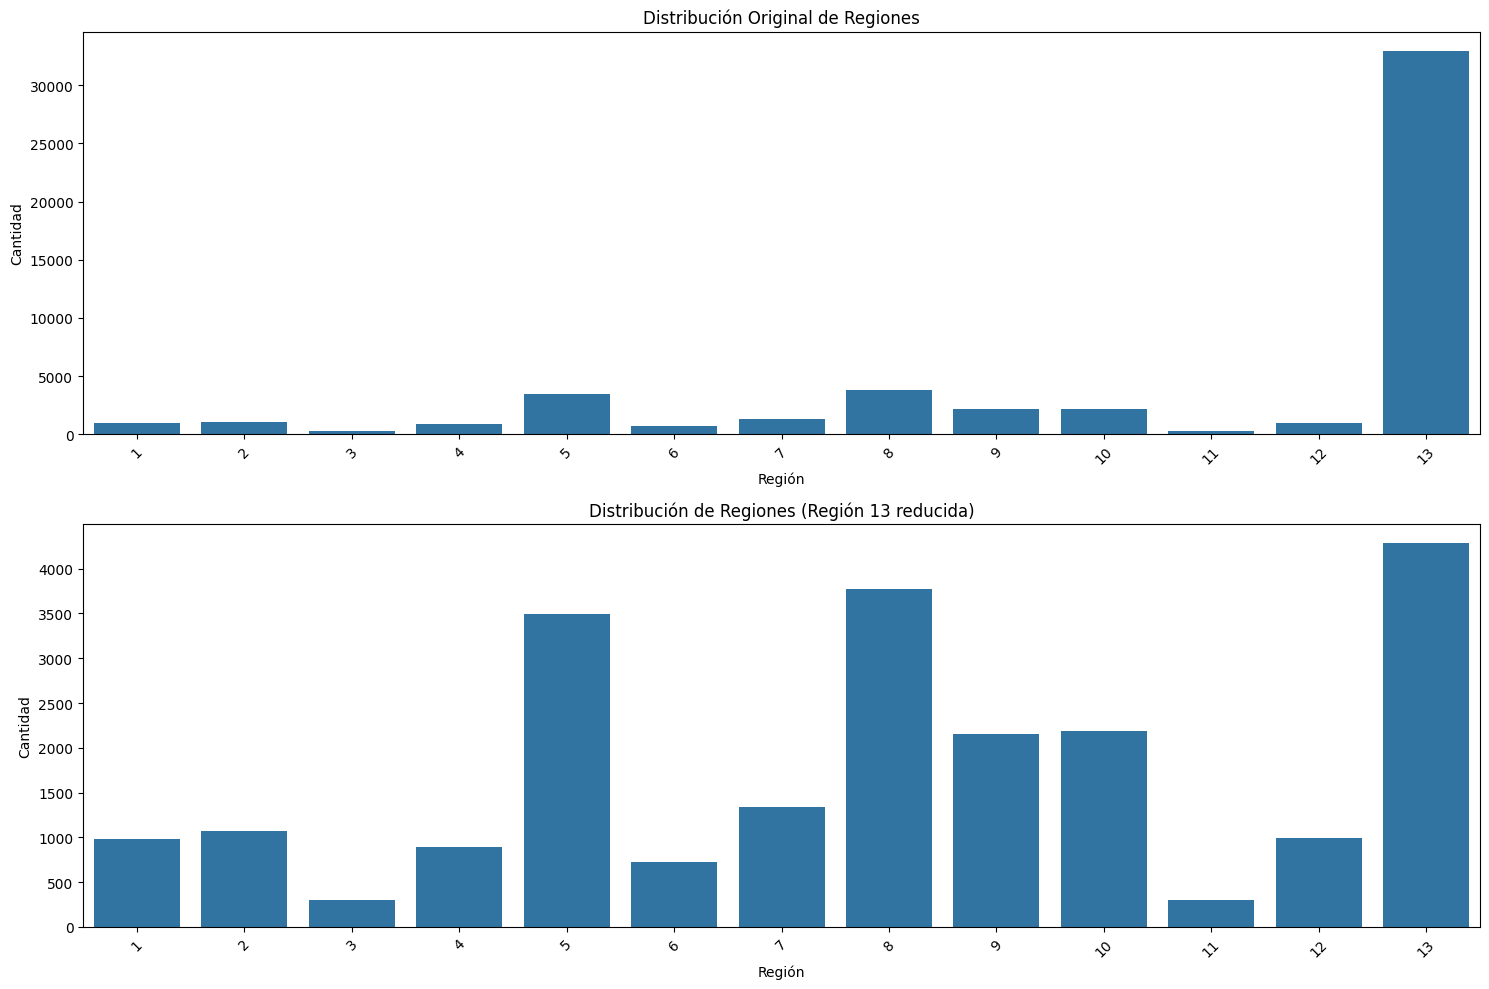


Estadísticas del filtrado:

Distribución final:
Region
13    4282
8     3773
5     3489
10    2187
9     2151
7     1334
2     1072
12     995
1      979
4      889
6      721
11     299
3      294
Name: count, dtype: int64

Registros originales: 51123
Registros después de la reducción: 22465
Registros eliminados: 28658
Porcentaje de registros eliminados: 56.06%


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar distribución original
print("Distribución original:")
print(ds['Region'].value_counts())

# Separar los datos de la región 13 y el resto
datos_region_13 = ds[ds['Region'] == 13]
datos_otras_regiones = ds[ds['Region'] != 13]

# Calcular cuántas filas mantener de la región 13 (40% del total)
n_mantener = int(len(datos_region_13) * 0.13)

# Tomar una muestra aleatoria del 40% de los datos de la región 13
datos_region_13_reducidos = datos_region_13.sample(n=n_mantener, random_state=42)

# Combinar los datos
ds2 = pd.concat([datos_otras_regiones, datos_region_13_reducidos])

# Visualización antes y después
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico original
sns.barplot(x=ds['Region'].value_counts().index, 
            y=ds['Region'].value_counts().values, 
            ax=ax1)
ax1.set_title('Distribución Original de Regiones')
ax1.set_xlabel('Región')
ax1.set_ylabel('Cantidad')
ax1.tick_params(axis='x', rotation=45)

# Gráfico después de la reducción
sns.barplot(x=ds2['Region'].value_counts().index, 
            y=ds2['Region'].value_counts().values, 
            ax=ax2)
ax2.set_title('Distribución de Regiones (Región 13 reducida)')
ax2.set_xlabel('Región')
ax2.set_ylabel('Cantidad')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar estadísticas
print("\nEstadísticas del filtrado:")
print("\nDistribución final:")
print(ds2['Region'].value_counts())
print(f"\nRegistros originales: {len(ds)}")
print(f"Registros después de la reducción: {len(ds2)}")
print(f"Registros eliminados: {len(ds) - len(ds2)}")
print(f"Porcentaje de registros eliminados: {((len(ds) - len(ds2))/len(ds)*100):.2f}%")

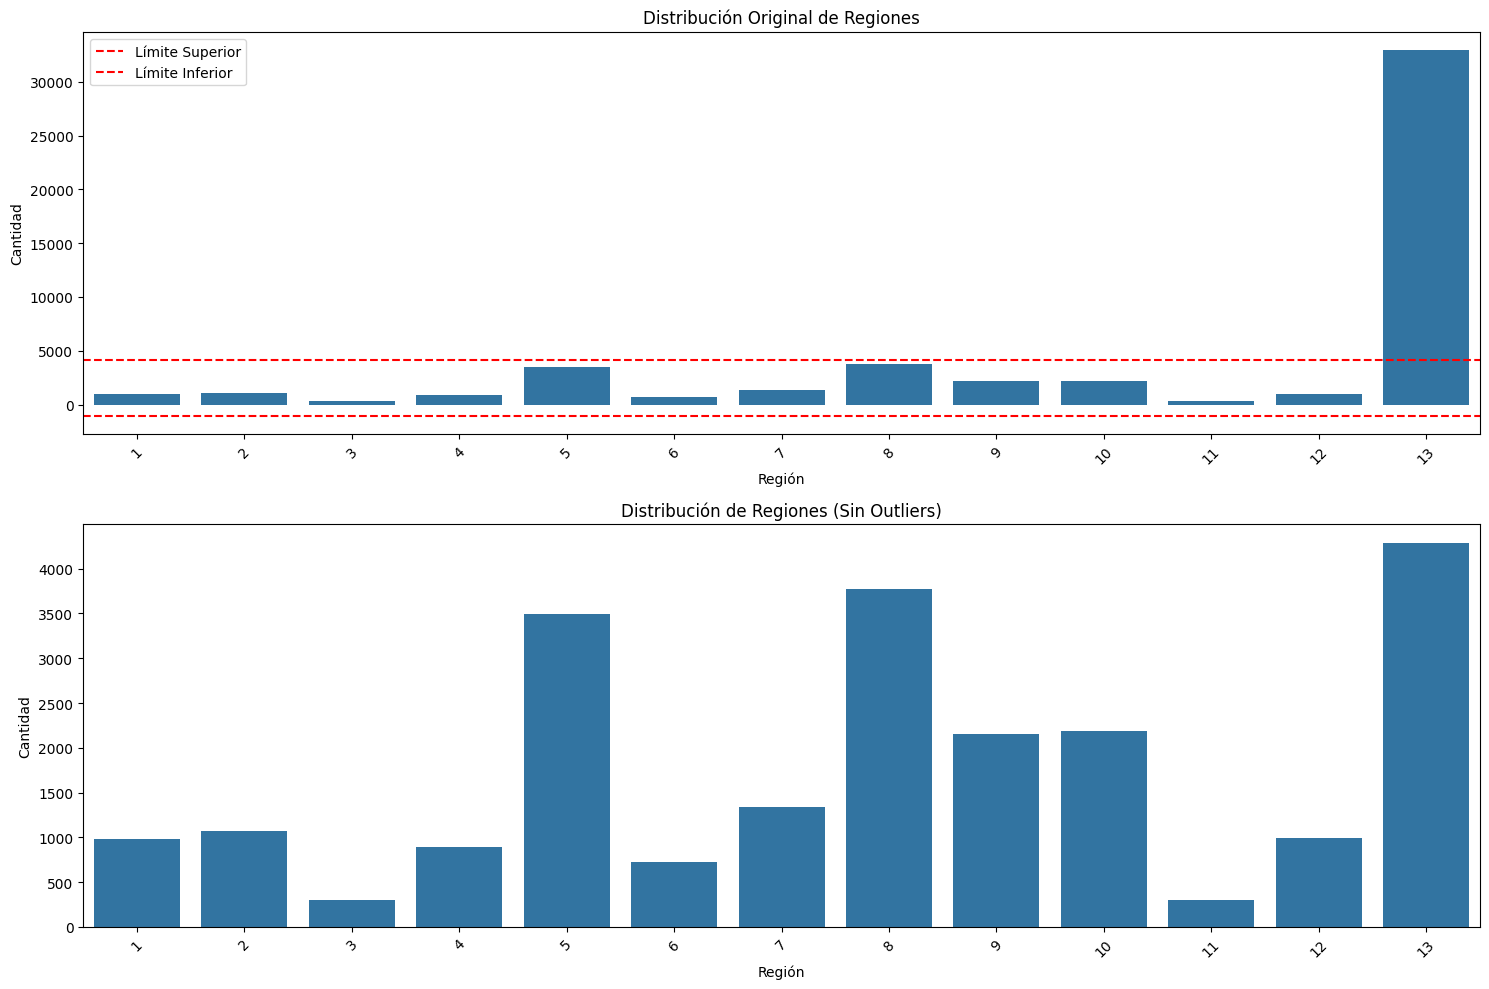


Estadísticas del filtrado:
Q1: 889.00
Q3: 2187.00
IQR: 1298.00
Límite inferior: -1058.00
Límite superior: 4134.00

Registros originales: 51123
Registros después del filtrado: 22465
Registros eliminados: 28658
Porcentaje de registros eliminados: 56.06%


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Contar filas por región
conteo_region = ds['Region'].value_counts()

# Calcular Q1, Q3 e IQR
Q1 = conteo_region.quantile(0.25)
Q3 = conteo_region.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar regiones dentro de los límites
regiones_validas = conteo_region[(conteo_region >= limite_inferior) & 
                                (conteo_region <= limite_superior)].index


# Visualización antes y después
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico original
sns.barplot(x=conteo_region.index, y=conteo_region.values, ax=ax1)
ax1.set_title('Distribución Original de Regiones')
ax1.set_xlabel('Región')
ax1.set_ylabel('Cantidad')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=limite_superior, color='r', linestyle='--', label='Límite Superior')
ax1.axhline(y=limite_inferior, color='r', linestyle='--', label='Límite Inferior')
ax1.legend()

# Gráfico después de eliminar outliers
conteo_region_nuevo = ds2['Region'].value_counts()
sns.barplot(x=conteo_region_nuevo.index, y=conteo_region_nuevo.values, ax=ax2)
ax2.set_title('Distribución de Regiones (Sin Outliers)')
ax2.set_xlabel('Región')
ax2.set_ylabel('Cantidad')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar estadísticas
print("\nEstadísticas del filtrado:")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Límite inferior: {limite_inferior:.2f}")
print(f"Límite superior: {limite_superior:.2f}")

print(f"\nRegistros originales: {len(ds)}")
print(f"Registros después del filtrado: {len(ds2)}")
print(f"Registros eliminados: {len(ds) - len(ds2)}")
print(f"Porcentaje de registros eliminados: {((len(ds) - len(ds2))/len(ds)*100):.2f}%")

In [27]:
# Importar las bibliotecas necesarias
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Resetear el índice del dataframe si es necesario
ds2 = ds2.reset_index(drop=True)

# Identificar columnas numéricas y categóricas
# Excluimos 'Id' ya que es un identificador y no una característica predictiva
numeric_features = ds2.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ds2.select_dtypes(include=['object']).columns
# Removemos 'Id' y 'Edad' de las características si están en las listas
numeric_features = [col for col in numeric_features if col not in ['Id', 'Edad']]
categorical_features = [col for col in categorical_features if col not in ['Id', 'Edad']]

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Separar features y target
X = ds2.drop(['Edad', 'Id'], axis=1)
y = ds2['Edad']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar el preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Crear y ajustar el modelo Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_processed, y_train)

# Obtener el score del modelo
score = lasso.score(X_test_processed, y_test)

# Obtener los nombres de las características después del one-hot encoding
feature_names = (numeric_features + 
                [f"{feature}_{val}" for feature, vals in 
                 zip(categorical_features, preprocessor.named_transformers_['cat'].categories_) 
                 for val in vals[1:]])

# Mostrar resultados
print(f"R² Score: {score:.4f}")
print("\nCoeficientes diferentes de cero:")
for feature, coef in zip(feature_names, lasso.coef_):
    if abs(coef) > 0.01:  # Mostramos solo los coeficientes más significativos
        print(f"{feature}: {coef:.4f}")

R² Score: 0.5035

Coeficientes diferentes de cero:
Region: -0.3046
Renta: 1.0464
Subsegmento: -4.5393
Adicional: 0.0887
Antiguedad: 2.9088
Consumo: 0.0543
Debito: -1.4785
Ctacte: 0.3351
Cuentas: -1.8870
Hipotecario: -0.1391
Internauta: -2.6226
Monoproducto: -0.0242
TC: 0.9659
Dualidad: 0.3013
CUPO_L1: 1.8508
CUPO_MX: 0.5441
CUPO_L2: 0.2074
Col_T12: -0.3924
ColL1TE_T12: -0.5531
EeccInt_T12: -0.1313
FacAI_T12: 0.1152
FacAN_T12: 0.2348
FacCCOT_T12: 0.0723
FacCI_T12: -0.0392
FacCOL_T12: -0.1043
FacDebAtm_T12: 0.3866
FacDebCom_T12: -0.1550
FacPAT_T12: -0.0955
FlgAct_T12: 0.3051
FlgActAI_T12: -0.1023
FlgActAN_T12: -0.1579
FlgActCCOT_T12: -0.2154
FlgActCCPC_T12: -0.2352
FlgActCI_T12: -0.0978
FlgActPAT_T12: -0.0128
PagoInt_T12: -0.1326
PagoNac_T12: 0.0482
Txs_T12: 0.0748
TxsAI_T12: -0.0325
TxsAN_T12: -0.1292
TxsCCOT_T12: 0.0193
TxsCCPC_T12: 0.0233
TxsDebAtm_T12: -0.5815
TxsDebCom_T12: -0.1859
TxsPAT_T12: 0.6469
UsoL1_T12: 0.9704
UsoL2_T12: 0.1875
Sexo_M: -0.0765


Fase 4

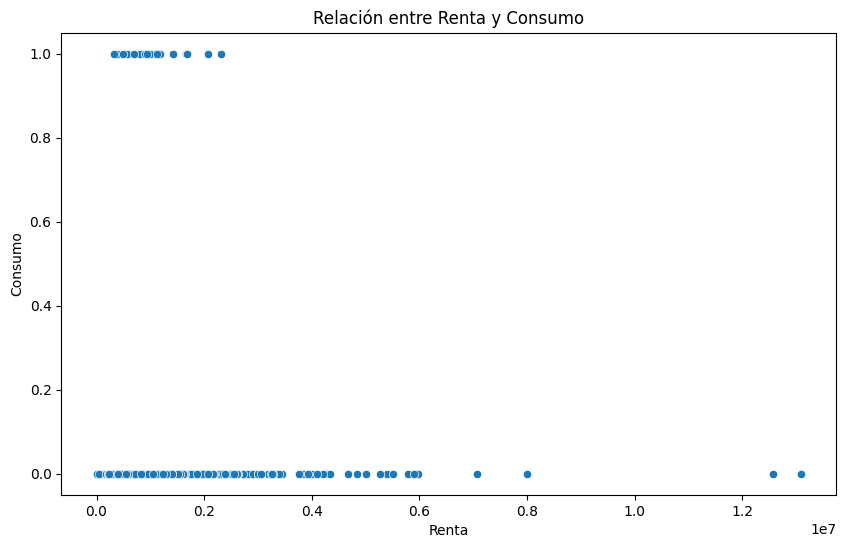

In [44]:
# Visualizar la relación entre Renta y Consumo
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ds2['Renta'], y=ds2['Consumo'])
plt.title('Relación entre Renta y Consumo')
plt.xlabel('Renta')
plt.ylabel('Consumo')
plt.show()

Modelo de regresion:


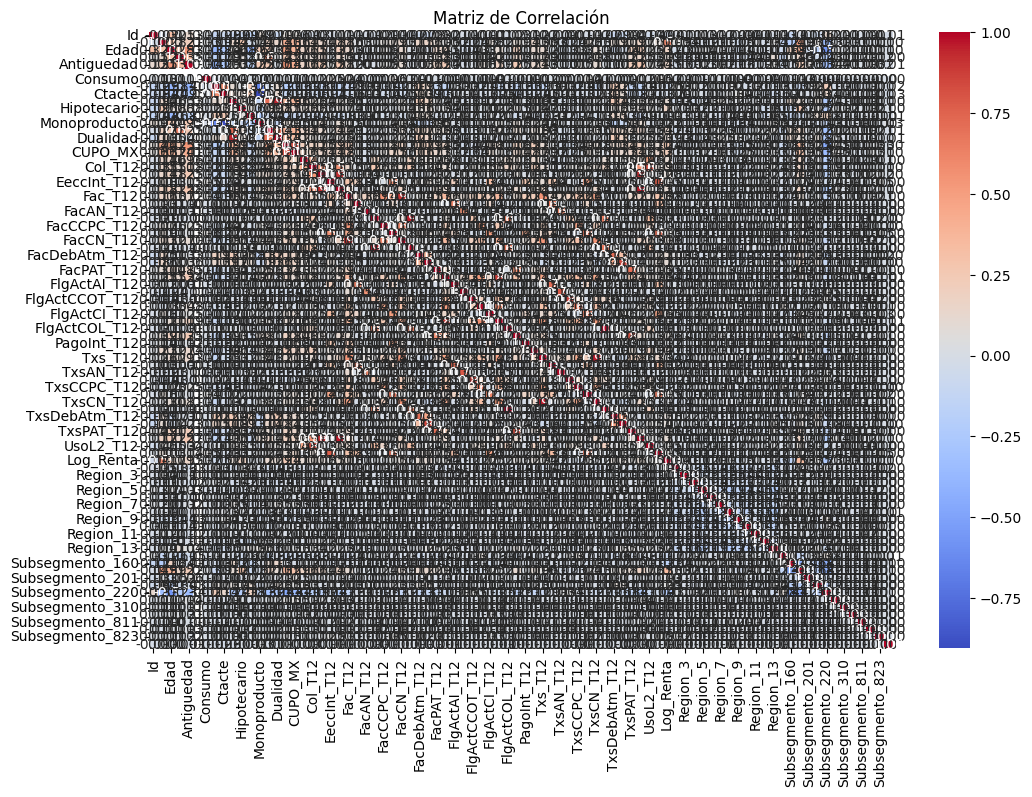

In [48]:
# Calcular y visualizar la matriz de correlación
correlation_matrix = ds2.corr()  # Calcular la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

In [70]:
# 2. Pregunta 1: Factores sociodemográficos que influyen en el uso de productos financieros
# Definir la variable objetivo y las características
X = ds2[['Renta', 'Edad', 'Antiguedad', 'Dualidad']]  # Variables seleccionadas
y = ds2['Consumo']  # Suponiendo que 'Consumo' es la variable objetivo

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [71]:
# 1. Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluar el modelo de regresión lineal
linear_r2 = r2_score(y_test, y_pred_linear)
linear_mse = mean_squared_error(y_test, y_pred_linear)


In [72]:
# 2. Regresión Lasso
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluar el modelo de regresión Lasso
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)



In [73]:
# 3. Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)  # No escalamos para Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo de Random Forest
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)

In [74]:
# 4. Ajuste de Hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluar el mejor modelo de Random Forest
best_rf_r2 = r2_score(y_test, y_pred_best_rf)
best_rf_mse = mean_squared_error(y_test, y_pred_best_rf)

In [76]:
# Resultados
results = {
    'Modelo': ['Regresión Lineal', 'Regresión Lasso', 'Random Forest', 'Mejor Random Forest'],
    'R² Score': [linear_r2, lasso_r2, rf_r2, best_rf_r2],
    'MSE': [linear_mse, lasso_mse, rf_mse, best_rf_mse]
}

results_df = pd.DataFrame(results)

# Imprimir los resultados
print("Resultados de los Modelos de Regresión:")
print(results_df)

# Imprimir el mejor modelo
print("\nMejor modelo de Random Forest:")
print(best_rf_model)

Resultados de los Modelos de Regresión:
                Modelo  R² Score       MSE
0     Regresión Lineal  0.000190  0.002220
1      Regresión Lasso -0.000942  0.002223
2        Random Forest -0.037519  0.002304
3  Mejor Random Forest -0.028947  0.002285

Mejor modelo de Random Forest:
RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)


In [53]:
# 4. Pregunta 2: Comparar ingresos y transacciones entre clientes con dualidad y monoproducto
dualidad_mean = ds2[ds2['Dualidad'] == 1]['Consumo'].mean()
monoproducto_mean = ds2[ds2['Dualidad'] == 0]['Consumo'].mean()

print(f'Consumo promedio (Dualidad): {dualidad_mean}')
print(f'Consumo promedio (Monoproducto): {monoproducto_mean}')


Consumo promedio (Dualidad): 0.0012727062362605577
Consumo promedio (Monoproducto): 0.000940529590507886


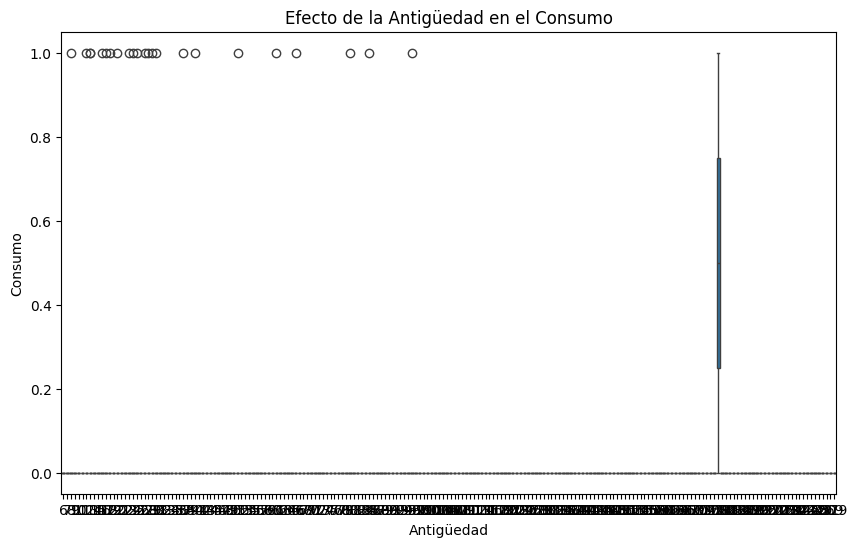

In [54]:
# 5. Pregunta 3: Efecto de la antigüedad en el uso de líneas de crédito
plt.figure(figsize=(10, 6))
sns.boxplot(x='Antiguedad', y='Consumo', data=ds2)
plt.title('Efecto de la Antigüedad en el Consumo')
plt.xlabel('Antigüedad')
plt.ylabel('Consumo')
plt.show()


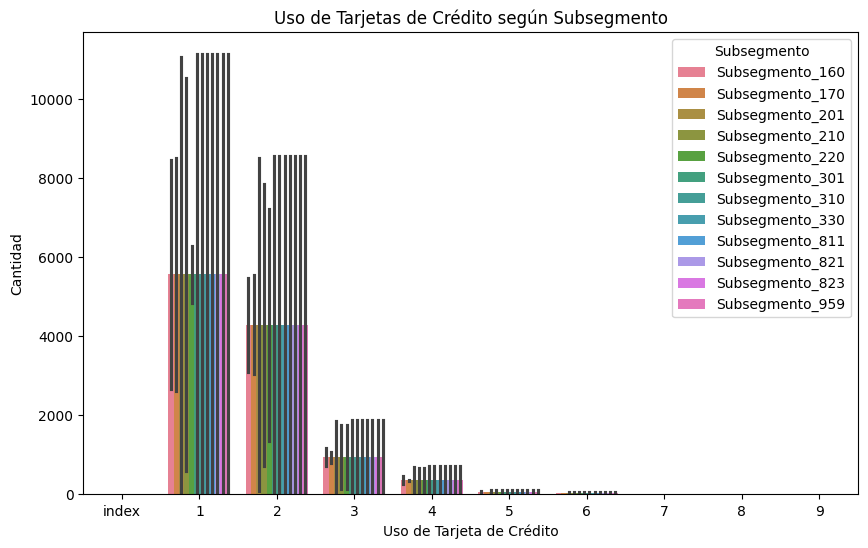

In [64]:
# 6. Pregunta 4: Patrones de comportamiento en el uso de tarjetas de crédito y débito

# Asegurarse de que 'TC' sea una variable categórica
ds2['TC'] = ds2['TC'].astype(str)  # Convertir a string si es necesario

# Contar el uso de tarjetas de crédito por subsegmento
subsegmento_columns = [col for col in ds2.columns if 'Subsegmento_' in col]

# Crear un DataFrame para almacenar los conteos
usage_counts = pd.DataFrame()

# Contar el uso de tarjetas de crédito para cada subsegmento
for subseg in subsegmento_columns:
    count = ds2.groupby([subseg, 'TC']).size().unstack(fill_value=0)
    count['Subsegmento'] = subseg
    usage_counts = pd.concat([usage_counts, count], axis=0)

# Resetear el índice para facilitar el uso en el gráfico
usage_counts.reset_index(inplace=True)

# Graficar el uso de tarjetas de crédito según subsegmento
plt.figure(figsize=(10, 6))

# Asegurarse de que los valores de 'TC' sean los correctos
usage_counts_melted = usage_counts.melt(id_vars='Subsegmento', 
                                          value_vars=usage_counts.columns[usage_counts.columns != 'Subsegmento'], 
                                          var_name='Uso de Tarjeta de Crédito', 
                                          value_name='Cantidad')

sns.barplot(data=usage_counts_melted, x='Uso de Tarjeta de Crédito', y='Cantidad', hue='Subsegmento')
plt.title('Uso de Tarjetas de Crédito según Subsegmento')
plt.xlabel('Uso de Tarjeta de Crédito')
plt.ylabel('Cantidad')
plt.legend(title='Subsegmento')
plt.show()

In [60]:
# 7. Modelos de Clasificación

# Definir la variable objetivo y las características para clasificación
X_class = ds2[['Renta', 'Edad', 'Antiguedad', 'Dualidad']]  # Variables seleccionadas

# Seleccionar una de las columnas dummy para 'Subsegmento'
# Por ejemplo, seleccionamos 'Subsegmento_160' como variable objetivo
y_class = ds2['Subsegmento_160']  # Cambia esto según el subsegmento que desees analizar

# Dividir los datos
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_class_resampled, y_train_class_resampled = smote.fit_resample(X_train_class, y_train_class)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento original: {X_train_class.shape[0]}")
print(f"Tamaño del conjunto de entrenamiento balanceado: {X_train_class_resampled.shape[0]}")

Tamaño del conjunto de entrenamiento original: 17972
Tamaño del conjunto de entrenamiento balanceado: 25160


In [61]:
# Regresión Logística
logistic_model = LogisticRegression()
logistic_model.fit(X_train_class_resampled, y_train_class_resampled)
y_pred_class = logistic_model.predict(X_test_class)

# Evaluar el modelo de regresión logística
print("\nRegresión Logística:")
print(confusion_matrix(y_test_class, y_pred_class))
print(classification_report(y_test_class, y_pred_class))


Regresión Logística:
[[2064 1034]
 [ 347 1048]]
              precision    recall  f1-score   support

       False       0.86      0.67      0.75      3098
        True       0.50      0.75      0.60      1395

    accuracy                           0.69      4493
   macro avg       0.68      0.71      0.68      4493
weighted avg       0.75      0.69      0.70      4493



In [62]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_class_resampled, y_train_class_resampled)
y_pred_rf_class = rf_classifier.predict(X_test_class)

# Evaluar el modelo de Random Forest Classifier
print("\nRandom Forest Classifier:")
print(confusion_matrix(y_test_class, y_pred_rf_class))
print(classification_report(y_test_class, y_pred_rf_class))


Random Forest Classifier:
[[2630  468]
 [ 335 1060]]
              precision    recall  f1-score   support

       False       0.89      0.85      0.87      3098
        True       0.69      0.76      0.73      1395

    accuracy                           0.82      4493
   macro avg       0.79      0.80      0.80      4493
weighted avg       0.83      0.82      0.82      4493



In [63]:
# 8. Optimización de Hiperparámetros con GridSearchCV para Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_class_resampled, y_train_class_resampled)

# Mejor modelo
best_rf_model = grid_search.best_estimator_
y_pred_best_rf_class = best_rf_model.predict(X_test_class)

# Evaluar el mejor modelo de Random Forest
print("\nMejor Random Forest Classifier:")
print(confusion_matrix(y_test_class, y_pred_best_rf_class))
print(classification_report(y_test_class, y_pred_best_rf_class))


Mejor Random Forest Classifier:
[[2652  446]
 [ 337 1058]]
              precision    recall  f1-score   support

       False       0.89      0.86      0.87      3098
        True       0.70      0.76      0.73      1395

    accuracy                           0.83      4493
   macro avg       0.80      0.81      0.80      4493
weighted avg       0.83      0.83      0.83      4493

